In [8]:
from keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, \
Dropout, Activation, Input, Flatten, Concatenate
from keras.models import Model
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
              
def cnn_model(FILTER_SIZES, \
              # filter sizes as a list
              MAX_NB_WORDS, \
              # total number of words
              MAX_DOC_LEN, \
              # max words in a doc
              EMBEDDING_DIM=200, \
              # word vector dimension
              NUM_FILTERS=64, \
              # number of filters for all size
              DROP_OUT=0.5, \
              # dropout rate
              NUM_OUTPUT_UNITS=1, \
              # number of output units
              NUM_DENSE_UNITS=100,\
              # number of units in dense layer
              PRETRAINED_WORD_VECTOR=None,\
              # Whether to use pretrained word vectors
              LAM=0.0):            
              # regularization coefficient
    
    main_input = Input(shape=(MAX_DOC_LEN,), \
                       dtype='int32', name='main_input')
    
    if PRETRAINED_WORD_VECTOR is not None:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        weights=[PRETRAINED_WORD_VECTOR],\
                        trainable=False,\
                        name='embedding')(main_input)
    else:
        embed_1 = Embedding(input_dim=MAX_NB_WORDS+1, \
                        output_dim=EMBEDDING_DIM, \
                        input_length=MAX_DOC_LEN, \
                        name='embedding')(main_input)
    # add convolution-pooling-flat block
    conv_blocks = []
    for f in FILTER_SIZES:
        conv = Conv1D(filters=NUM_FILTERS, kernel_size=f, \
                      activation='relu', name='conv_'+str(f))(embed_1)
        conv = MaxPooling1D(MAX_DOC_LEN-f+1, name='max_'+str(f))(conv)
        conv = Flatten(name='flat_'+str(f))(conv)
        conv_blocks.append(conv)
    
    if len(conv_blocks)>1:
        z=Concatenate(name='concate')(conv_blocks)
    else:
        z=conv_blocks[0]
        
    drop=Dropout(rate=DROP_OUT, name='dropout')(z)

    dense = Dense(NUM_DENSE_UNITS, activation='relu',\
                    kernel_regularizer=l2(LAM),name='dense')(drop)
    preds = Dense(NUM_OUTPUT_UNITS, activation='sigmoid', name='output')(dense)
    model = Model(inputs=main_input, outputs=preds)
    
    model.compile(loss="binary_crossentropy", \
              optimizer="adam", metrics=["accuracy"]) 
    
    return model

In [70]:
import pandas as pd
import nltk,string

# Load data
data=pd.read_csv('../dataset/imdb_reviews.csv', header=0, sep="\t")
#data.columns=['label','text']
#data['label']=data['label'].apply(lambda x:x-1)
print(data.head())
len(data)


       id  sentiment                                             review
0  5814_8          1  With all this stuff going down at the moment w...
1  2381_9          1  \The Classic War of the Worlds\" by Timothy Hi...
2  7759_3          0  The film starts with a manager (Nicholas Bell)...
3  3630_4          0  It must be assumed that those who praised this...
4  9495_8          1  Superbly trashy and wondrously unpretentious 8...


25000

In [71]:
from sklearn.utils import shuffle
data=shuffle(data)
train_set=data.iloc[0:1000]
test_set=data.iloc[1000:1200]

In [73]:
train_set[["review","sentiment"]].to_csv("train.csv", header=True, index=False)
test_set[["review","sentiment"]].to_csv("test.csv", header=True, index=False)

In [63]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np

# set the maximum number of words to be used
MAX_NB_WORDS=12000

# set sentence/document length
MAX_DOC_LEN=1000

# get a Keras tokenizer
# https://keras.io/preprocessing/text/
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_set["review"])

# convert each document to a list of word index as a sequence
sequences = tokenizer.texts_to_sequences(train_set["review"])

# pad all sequences into the same length 
# if a sentence is longer than maxlen, pad it in the right
# if a sentence is shorter than maxlen, truncate it in the right
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_set["review"])

# pad all sequences into the same length 
# if a sentence is longer than maxlen, pad it in the right
# if a sentence is shorter than maxlen, truncate it in the right
padded_test_sequences = pad_sequences(test_sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')



In [64]:
len(tokenizer.word_counts)

18759

In [66]:
EMBEDDING_DIM=300
FILTER_SIZES=[2,3,4]

# set the number of output units
# as the number of classes
output_units_num=1
num_filters=64

# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)

BTACH_SIZE = 32
NUM_EPOCHES = 100

BEST_MODEL_FILEPATH='best_model'

# With well trained word vectors, sample size can be reduced
# Assume we only have 500 labeled data
# split dataset into train (70%) and test sets (20%)

# create the model with embedding matrix
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, \
                EMBEDDING_DIM=300,\
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_FILTERS=num_filters,\
                NUM_DENSE_UNITS=dense_units_num)

earlyStopping=EarlyStopping(monitor='val_loss', patience=1, verbose=2, mode='min')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', \
                             verbose=2, save_best_only=True, mode='max')
    
training=model.fit(padded_sequences, train_set["sentiment"], \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[padded_test_sequences, test_set["sentiment"]], verbose=2)

Train on 1000 samples, validate on 200 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.54500, saving model to best_model
19s - loss: 0.6971 - acc: 0.4900 - val_loss: 0.6774 - val_acc: 0.5450
Epoch 2/100
Epoch 00001: val_acc improved from 0.54500 to 0.70000, saving model to best_model
19s - loss: 0.6330 - acc: 0.7020 - val_loss: 0.6183 - val_acc: 0.7000
Epoch 3/100
Epoch 00002: val_acc improved from 0.70000 to 0.76500, saving model to best_model
21s - loss: 0.4889 - acc: 0.8030 - val_loss: 0.5373 - val_acc: 0.7650
Epoch 4/100
Epoch 00003: val_acc improved from 0.76500 to 0.78500, saving model to best_model
20s - loss: 0.2835 - acc: 0.9010 - val_loss: 0.4478 - val_acc: 0.7850
Epoch 5/100
Epoch 00004: val_acc did not improve
19s - loss: 0.1405 - acc: 0.9590 - val_loss: 0.4319 - val_acc: 0.7700
Epoch 6/100
Epoch 00005: val_acc did not improve
19s - loss: 0.0650 - acc: 0.9860 - val_loss: 0.4356 - val_acc: 0.7650
Epoch 7/100
Epoch 00006: val_acc did not improve
19s - loss: 0

In [15]:
from sklearn.metrics import classification_report

model.load_weights("best_model")

# predict
pred=model.predict(padded_test_sequences)
pred=np.where(pred>0.5,1,0)
print(pred[0:5])
# evaluate the model
scores = model.evaluate(padded_test_sequences, test_set["sentiment"], verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print(classification_report(test_set["sentiment"], pred))

[[1]
 [1]
 [1]
 [1]
 [0]]
acc: 83.50%
             precision    recall  f1-score   support

          0       0.82      0.86      0.84       102
          1       0.85      0.81      0.83        98

avg / total       0.84      0.83      0.83       200



In [17]:
sentences=[ [token.strip(string.punctuation).strip() \
             for token in nltk.word_tokenize(doc) \
                 if token not in string.punctuation and \
                 len(token.strip(string.punctuation).strip())>=2]\
             for doc in data["review"]]

In [18]:
print(len(sentences))

25000


In [41]:
from gensim.models import word2vec
import logging
import pandas as pd

# print out tracking information
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', \
                    level=logging.INFO)
EMBEDDING_DIM=200
wv_model = word2vec.Word2Vec(sentences, min_count=5, \
                             size=EMBEDDING_DIM, window=5, workers=4 )

2018-04-11 23:18:06,700 : INFO : collecting all words and their counts
2018-04-11 23:18:06,701 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-04-11 23:18:07,136 : INFO : PROGRESS: at sentence #10000, processed 2374499 words, keeping 74911 word types
2018-04-11 23:18:07,620 : INFO : PROGRESS: at sentence #20000, processed 4702314 words, keeping 105743 word types
2018-04-11 23:18:07,839 : INFO : collected 118815 word types from a corpus of 5872604 raw words and 25000 sentences
2018-04-11 23:18:07,840 : INFO : Loading a fresh vocabulary
2018-04-11 23:18:07,955 : INFO : min_count=5 retains 34361 unique words (28% of original 118815, drops 84454)
2018-04-11 23:18:07,956 : INFO : min_count=5 leaves 5744544 word corpus (97% of original 5872604, drops 128060)
2018-04-11 23:18:08,075 : INFO : deleting the raw counts dictionary of 118815 items
2018-04-11 23:18:08,077 : INFO : sample=0.001 downsamples 47 most-common words
2018-04-11 23:18:08,078 : INFO : downsampl

In [45]:
import gensim

wv_model = gensim.models.KeyedVectors.\
load_word2vec_format('/Users/rliu/bluemix/bia660/GoogleNews-vectors-negative300.bin', binary=True) 

#model.wv.most_similar(positive=['women','king'], negative='man')

2018-04-11 23:24:58,354 : INFO : loading projection weights from /Users/rliu/bluemix/bia660/GoogleNews-vectors-negative300.bin
2018-04-11 23:25:34,084 : INFO : loaded (3000000, 300) matrix from /Users/rliu/bluemix/bia660/GoogleNews-vectors-negative300.bin


In [67]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
 
import numpy as np

# set the maximum number of words to be used
MAX_NB_WORDS=12000

# set sentence/document length
MAX_DOC_LEN=1000

# get a Keras tokenizer
# https://keras.io/preprocessing/text/
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(train_set["review"])

# convert each document to a list of word index as a sequence
sequences = tokenizer.texts_to_sequences(train_set["review"])

# pad all sequences into the same length 
# if a sentence is longer than maxlen, pad it in the right
# if a sentence is shorter than maxlen, truncate it in the right
padded_sequences = pad_sequences(sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')

test_sequences = tokenizer.texts_to_sequences(test_set["review"])

# pad all sequences into the same length 
# if a sentence is longer than maxlen, pad it in the right
# if a sentence is shorter than maxlen, truncate it in the right
padded_test_sequences = pad_sequences(test_sequences, \
                                 maxlen=MAX_DOC_LEN, \
                                 padding='post', \
                                 truncating='post')




In [68]:
MAX_NB_WORDS=12000
EMBEDDING_DIM=300

# tokenizer.word_index provides the mapping 
# between a word and word index for all words
NUM_WORDS = min(MAX_NB_WORDS, len(tokenizer.word_index))

# "+1" is for padding symbol
embedding_matrix = np.zeros((NUM_WORDS+1, EMBEDDING_DIM))

ignored_words=[]
for word, i in tokenizer.word_index.items():
    # if word_index is above the max number of words, ignore it
    if i >= NUM_WORDS:
        continue
    if word in wv_model.wv:
        embedding_matrix[i]=wv_model.wv[word]
    else:
        ignored_words.append(word)
        
print(len(ignored_words))
print(ignored_words)

1639
['and', 'a', 'of', 'to', '10', "i'm", "i've", "i'd", "i'll", "film's", "'", '15', '–', 'lundgren', "movie's", "80's", '30', '000', 'paulie', '100', 'alvin', 'favourite', '90', '20', 'theatre', 'amrita', 'humour', '50', '70s', 'tarzan', 'lugosi', 'burgade', "70's", 'macarthur', "'the", 'mildred', 'herschel', '40', 'zandalee', 'karloff', 'zombi', 'sandler', 'walken', 'keaton', '13', 'maclean', "freddy's", 'gundam', '1972', 'digicorp', 'carface', 'foxx', 'flynn', 'othello', '11', 'grey', '60', "character's", 'ritter', "moore's", '1945', "keaton's", 'byron', "director's", 'mst3k', 'silverman', 'rukh', 'kazan', '14', 'fulci', '80s', 'gilliam', '60s', 'bettie', '2006', '1950s', 'mukhsin', '2000', "davis'", 'bsg', 'kolchak', 'dolph', '400', 'tolstoy', '1930s', 'heston', 'widmark', 'palance', 'carrey', 'timberlake', 'brando', 'sarandon', "60's", 'northam', 'truman', '80', '12', '45', 'tmnt', 'eastwood', 'callahan', 'soylent', 'fetchit', 'weller', 'cedric', 'micheaux', "'scoop'", 'romero',

In [69]:

EMBEDDING_DIM=300
FILTER_SIZES=[2,3,4]

# set the number of output units
# as the number of classes
output_units_num=1
num_filters=64

# set the dense units
dense_units_num= num_filters*len(FILTER_SIZES)

BTACH_SIZE = 32
NUM_EPOCHES = 100

# With well trained word vectors, sample size can be reduced
# Assume we only have 500 labeled data
# split dataset into train (70%) and test sets (20%)


# create the model with embedding matrix
model=cnn_model(FILTER_SIZES, MAX_NB_WORDS, \
                MAX_DOC_LEN, \
                EMBEDDING_DIM=300,\
                NUM_OUTPUT_UNITS=output_units_num, \
                NUM_FILTERS=num_filters,\
                NUM_DENSE_UNITS=dense_units_num,\
                PRETRAINED_WORD_VECTOR=embedding_matrix)

earlyStopping=EarlyStopping(monitor='val_acc', patience=3, verbose=2, mode='max')
checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_acc', \
                             verbose=2, save_best_only=True, mode='max')
    
training=model.fit(padded_sequences, train_set["sentiment"], \
          batch_size=BTACH_SIZE, epochs=NUM_EPOCHES, \
          callbacks=[earlyStopping, checkpoint],\
          validation_data=[padded_test_sequences, test_set["sentiment"]], verbose=2)

Train on 1000 samples, validate on 200 samples
Epoch 1/100
Epoch 00000: val_acc improved from -inf to 0.48500, saving model to best_model
15s - loss: 0.7047 - acc: 0.5210 - val_loss: 0.7026 - val_acc: 0.4850
Epoch 2/100
Epoch 00001: val_acc improved from 0.48500 to 0.61000, saving model to best_model
14s - loss: 0.6503 - acc: 0.6180 - val_loss: 0.6318 - val_acc: 0.6100
Epoch 3/100
Epoch 00002: val_acc did not improve
13s - loss: 0.5724 - acc: 0.7190 - val_loss: 0.5950 - val_acc: 0.6100
Epoch 4/100
Epoch 00003: val_acc improved from 0.61000 to 0.80500, saving model to best_model
13s - loss: 0.4735 - acc: 0.7930 - val_loss: 0.4609 - val_acc: 0.8050
Epoch 5/100
Epoch 00004: val_acc did not improve
14s - loss: 0.3371 - acc: 0.8760 - val_loss: 0.4180 - val_acc: 0.8000
Epoch 6/100
Epoch 00005: val_acc did not improve
13s - loss: 0.2858 - acc: 0.8880 - val_loss: 0.3986 - val_acc: 0.8050
Epoch 7/100
Epoch 00006: val_acc improved from 0.80500 to 0.85500, saving model to best_model
13s - loss: 0

In [68]:
from sklearn.metrics import classification_report

model.load_weights("best_model")

# predict
pred=model.predict(padded_test_sequences)
pred=np.where(pred>0.5,1,0)
print(pred[0:5])
# evaluate the model
scores = model.evaluate(padded_test_sequences, test_set["label"], verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

print(classification_report(test_set["label"], pred))

[[1]
 [1]
 [0]
 [0]
 [0]]
acc: 70.50%
             precision    recall  f1-score   support

          0       0.68      0.77      0.72        98
          1       0.74      0.65      0.69       102

avg / total       0.71      0.70      0.70       200



         freq
several    40
posters     5
have      911
quoted      1
renoir      6
   word_freq  count   percent    cumsum
0          1   8356  0.495170  0.495170
1          2   2688  0.159289  0.654459
2          3   1386  0.082133  0.736593
3          4    832  0.049304  0.785896
4          5    560  0.033185  0.819081


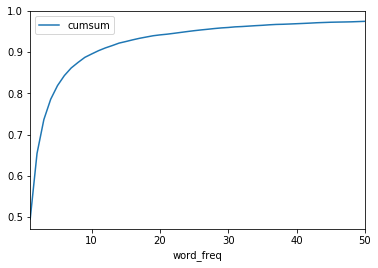

In [32]:
# Exercise 5.9.1 Set MAX_NB_WORDS to 
# include words that appear at least K times

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# get count of each word
df=pd.DataFrame.from_dict(tokenizer.word_counts, orient="index")
df.columns=['freq']
print(df.head())

# get histogram of word count
df=df['freq'].value_counts().reset_index()
df.columns=['word_freq','count']

# sort by word_freq
df=df.sort_values(by='word_freq')

# convert absolute counts to precentage
df['percent']=df['count']/len(tokenizer.word_counts)
# get cumulative percentage
df['cumsum']=df['percent'].cumsum()

print(df.head())

df.iloc[0:50].plot(x='word_freq', y='cumsum');

plt.show();

# if set min count for word to 10, 
# what % of words can be included?
# how many words will be included?
# This is the parameter MAX_NB_WORDS
# tokenizer = Tokenizer(num_words=MAX_NB_WORDS)

     sent_length  counts  percent   cumsum
188           10       1  0.00125  0.00125
195           28       1  0.00125  0.00250
184           36       1  0.00125  0.00375


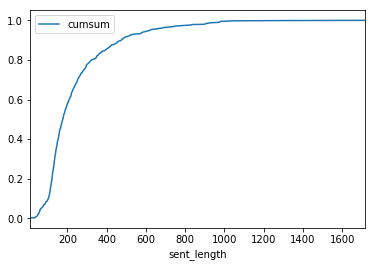

In [31]:
import pandas as pd

# create a series based on the length of all sentences
sen_len=pd.Series([len(item) for item in sequences])

# create histogram of sentence length
# the "index" is the sentence length
# "counts" is the count of sentences at a length
df=sen_len.value_counts().reset_index().sort_values(by='index')
df.columns=['sent_length','counts']

# sort by sentence length
# get percentage and cumulative percentage

df['percent']=df['counts']/len(sen_len)
df['cumsum']=df['percent'].cumsum()
print(df.head(3))

# From the plot, 90% sentences have length<500
# so it makes sense to set MAX_DOC_LEN=4~500 
df.plot(x="sent_length", y='cumsum');
plt.show();

# what will be the minimum sentence length
# such that 99% of sentences will not be truncated?